## Data extraction and preparation

In [1]:
!pip install pmdarima


     ------------------------------------ 572.7/572.7 kB 856.1 kB/s eta 0:00:00
     -------------------------------------- 987.3/987.3 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 9.2/9.2 MB 3.4 MB/s eta 0:00:00
     -------------------------------------- 233.8/233.8 kB 4.8 MB/s eta 0:00:00


In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


In [4]:
import yfinance as yf
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
stock_data = yf.download("TATAMOTORS.NS",period="max",interval="1d")

[*********************100%***********************]  1 of 1 completed


In [6]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1995-12-25,72.819626,72.819626,72.819626,72.819626,53.472790,0
1995-12-26,72.819626,72.819626,72.819626,72.819626,53.472790,0
1995-12-27,72.819626,72.819626,72.819626,72.819626,53.472790,0
1995-12-28,72.819626,72.819626,72.819626,72.819626,53.472790,0
1995-12-29,72.819626,72.819626,72.819626,72.819626,53.472790,0
...,...,...,...,...,...,...
2023-03-13,436.100006,437.000000,419.100006,422.399994,422.399994,8780169
2023-03-14,422.850006,424.200012,413.399994,416.649994,416.649994,9189043
2023-03-15,422.000000,425.000000,410.100006,411.350006,411.350006,7681009


### Visualize the stock’s daily closing price

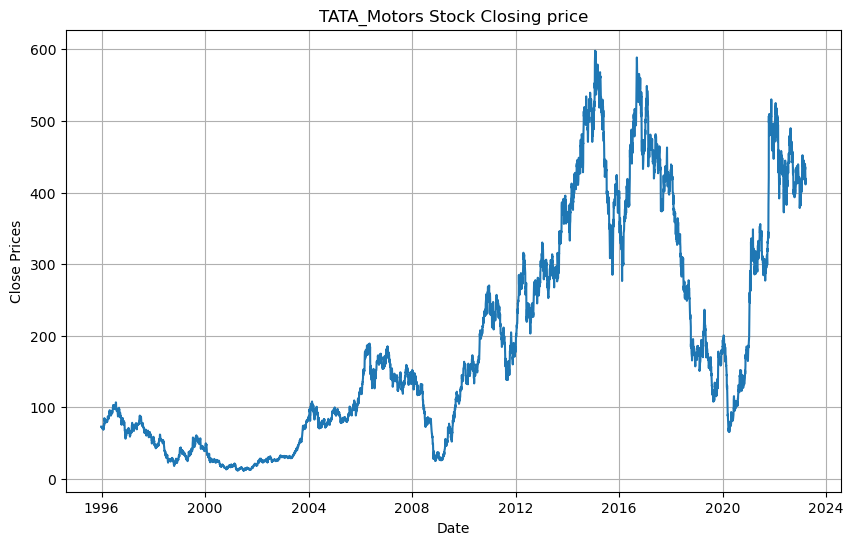

In [7]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('TATA_Motors Stock Closing price')
plt.show()

<Axes: ylabel='Density'>

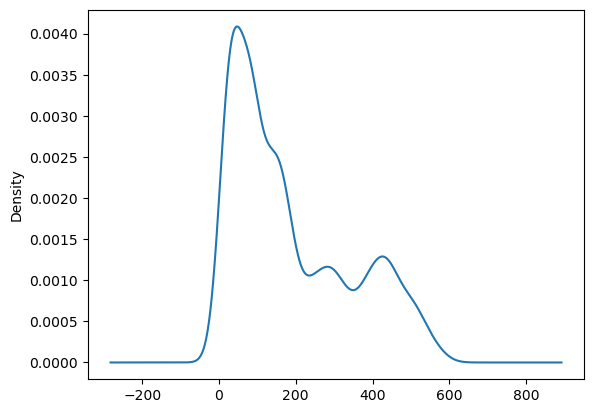

In [8]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

## ADF (Augmented Dickey-Fuller) Test
One of the most widely used statistical tests is the Dickey-Fuller test. It can be used to determine whether or not a series has a unit root, and thus whether or not the series is stationary. This test’s null and alternate hypotheses are:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If the null hypothesis is not rejected, the series is said to be non-stationary. The series can be linear or difference stationary as a result of this.

The series becomes stationary if both the mean and standard deviation are flat lines (constant mean and constant variance).

In [9]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

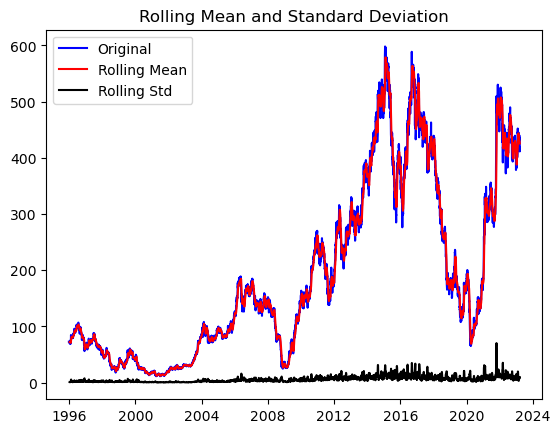

Results of dickey fuller test
Test Statistics                  -1.311510
p-value                           0.623890
No. of lags used                 21.000000
Number of observations used    6829.000000
critical value (1%)              -3.431308
critical value (5%)              -2.861963
critical value (10%)             -2.566995
dtype: float64


In [10]:
test_stationarity(df_close)

The increasing mean and standard deviation may be seen in the graph above, indicating that our series isn’t stationary.

We can’t rule out the Null hypothesis because the p-value is bigger than 0.05. Additionally, the test statistics exceed the critical values. As a result, the data is nonlinear.

Seasonality and trend may need to be separated from our series before we can undertake a time series analysis. This approach will cause the resulting series to become stagnant.

Let’s isolate the time series from the Trend and Seasonality.

<Figure size 640x480 with 0 Axes>

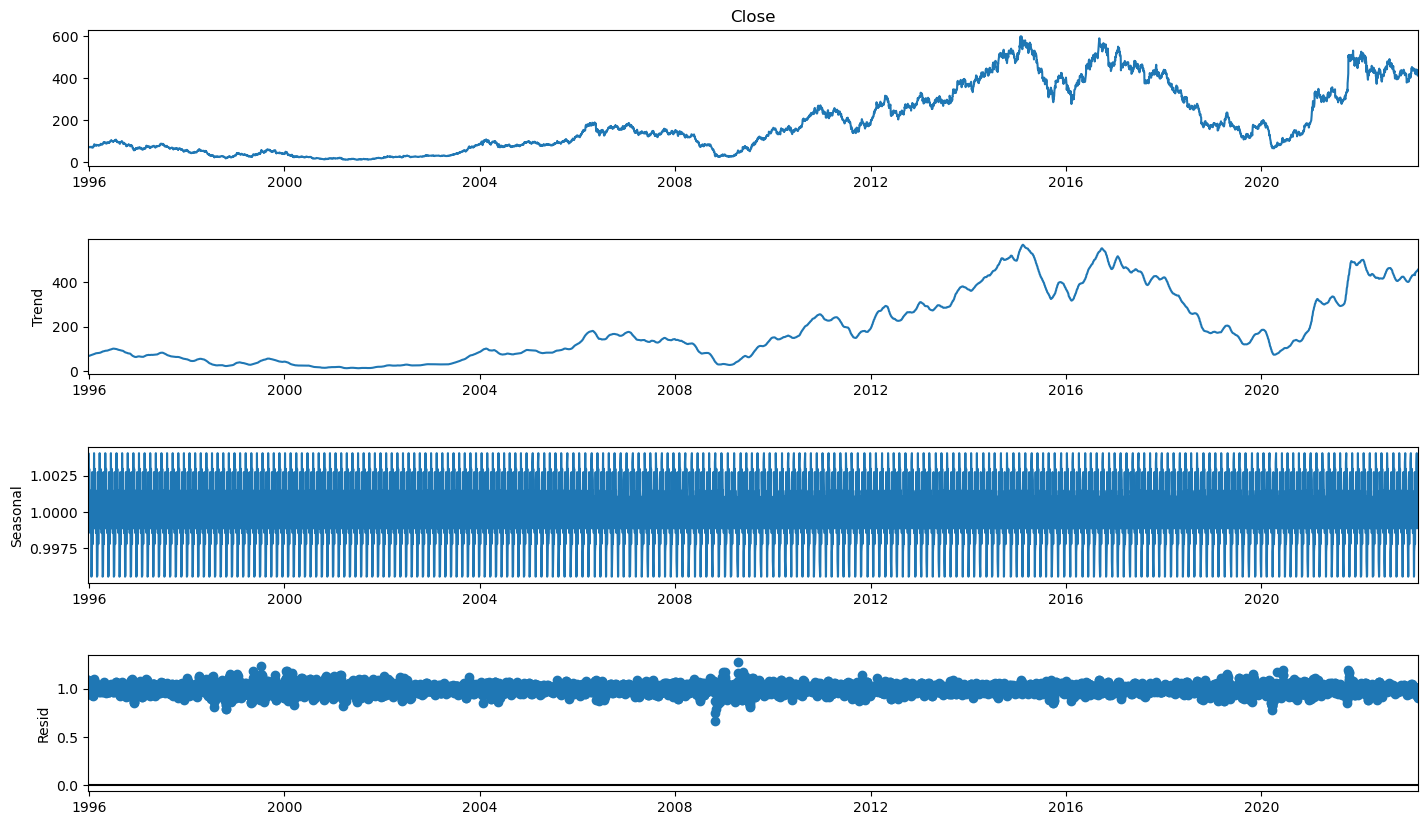

In [16]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative',extrapolate_trend='freq', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

To reduce the magnitude of the values and the growing trend in the series, we first take a log of the series. We then calculate the rolling average of the series after obtaining the log of the series. A rolling average is computed by taking data from the previous 12 months and calculating a mean consumption value at each subsequent point in the series.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


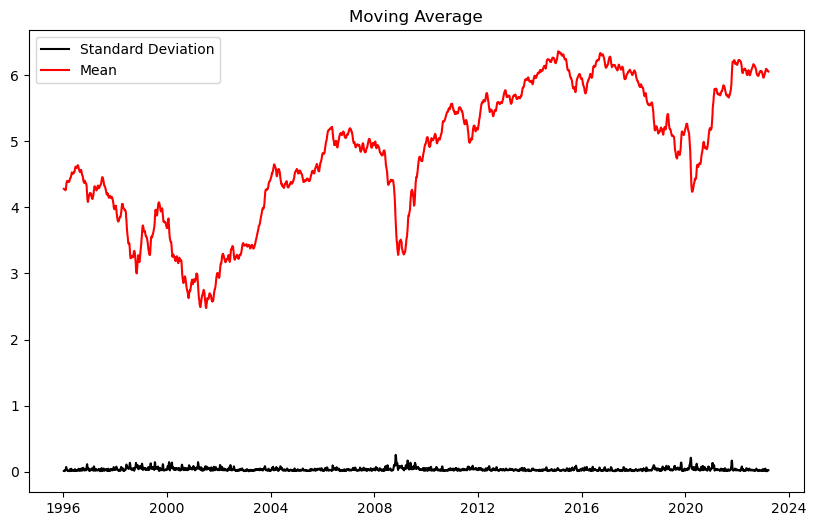

In [17]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now we’ll develop an ARIMA model and train it using the stock’s closing price from the train data. So, let’s visualize the data by dividing it into training and test sets.

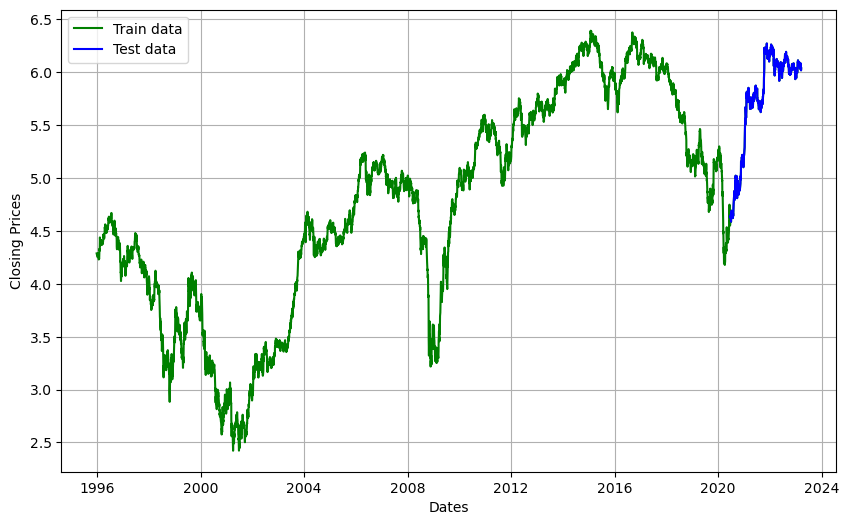

In [18]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

## Auto ARIMA: Automatically discover the optimal order for an ARIMA model.
The auto_arima function returns a fitted ARIMA model after determining the most optimal parameters for an ARIMA model. This function is based on the forecast::auto. Arima R function, which is widely used.

The auro_arima function works by performing differencing tests (e.g., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller, or Phillips–Perron) to determine the order of differencing, d, and then fitting models within start p, max p, start q, max q ranges. After conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D, auto_arima also seeks to identify the optimal P and Q hyper-parameters if the seasonal option is enabled.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-26255.633, Time=0.64 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-26283.636, Time=0.70 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-26284.143, Time=2.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-26257.618, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-26282.363, Time=1.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-26282.360, Time=1.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-26281.182, Time=1.67 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-26286.129, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-26284.350, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-26284.347, Time=0.72 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-26285.622, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-26282.994, Time=1.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 11.898 seconds
                               SARIMAX Results                 

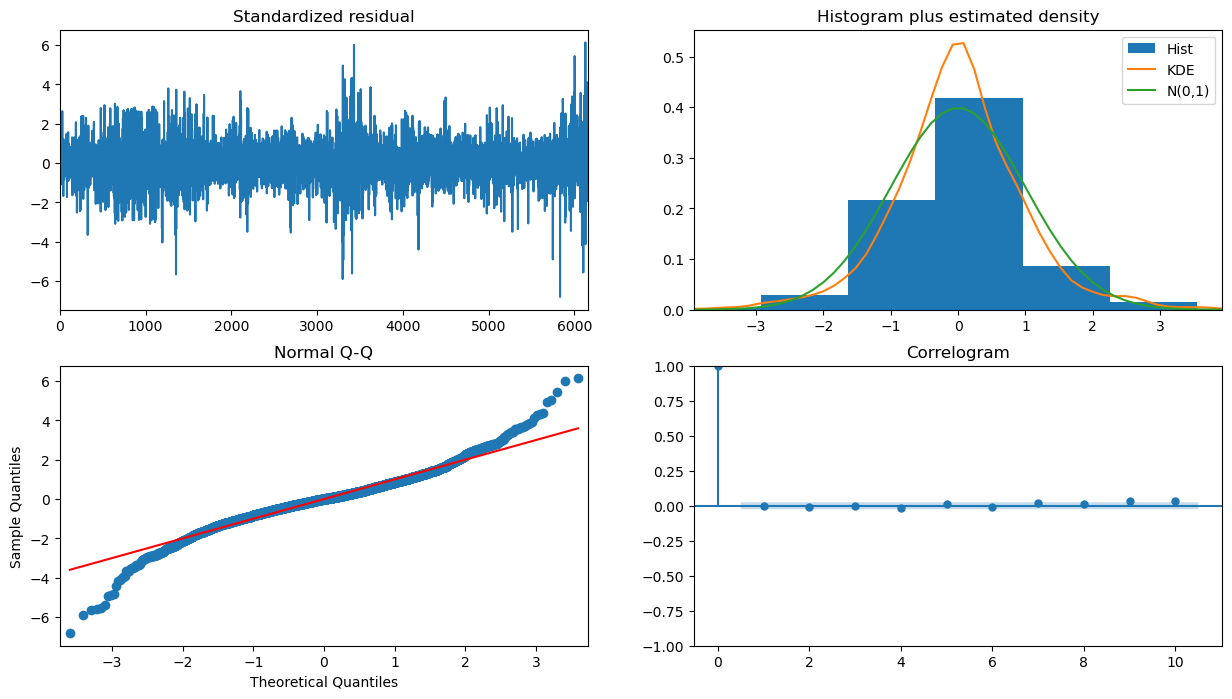

In [20]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()


So, how should the plot diagnostics be interpreted?
Top left: The residual errors appear to have a uniform variance and fluctuate around a mean of zero.

Top Right: The density plot on the top right suggests a normal distribution with a mean of zero.

Bottom left: The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.

Bottom Right: The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. As a result, you’ll need to add more Xs (predictors) to the model.

In [37]:
#Modeling
#Build Model
from statsmodels.tsa.arima.model import ARIMA

import statsmodels.api as smapi

model = smapi.tsa.arima.ARIMA(train_data, order=(1,1,2))

fitted = model.fit()
print(fitted.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 6162
Model:                 ARIMA(1, 1, 2)   Log Likelihood               13145.497
Date:                Sat, 18 Mar 2023   AIC                         -26282.994
Time:                        05:11:02   BIC                         -26256.090
Sample:                             0   HQIC                        -26273.664
                               - 6162                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5711      0.888     -0.643      0.520      -2.312       1.170
ma.L1          0.6417      0.888      0.723      0.470      -1.098       2.381
ma.L2          0.0341      0.067      0.508      0.6

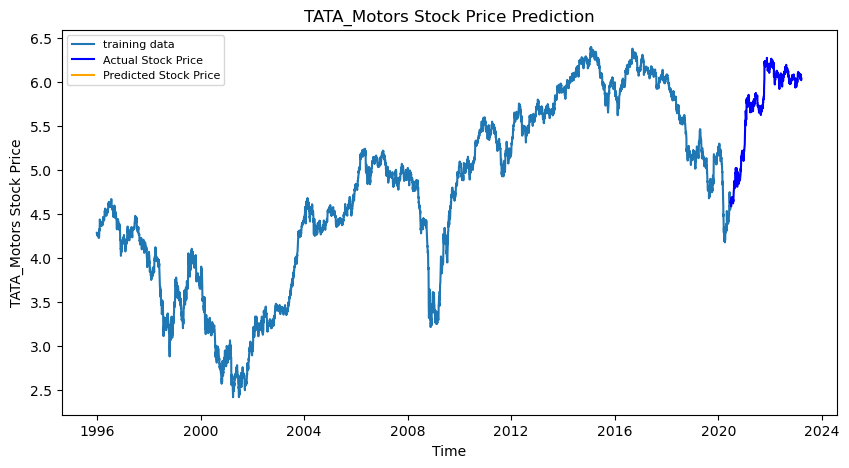

In [51]:
# Forecast
fc = fitted.forecast(len(test_data), alpha=0.05)  # 95% conf
#se = fitted.forecast(len(test_data), alpha=0.05)
#conf = fitted.forecast(len(test_data), alpha=0.05)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
#lower_series = pd.Series(conf[:, 0], index=test_data.index)
#upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('TATA_Motors Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TATA_Motors Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [48]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))


MSE: 1.6174982171064678
MAE: 1.183306230510432
RMSE: 1.2718090332697232
MAPE: nan
